# Simulations for Poisson naïve Bayes classifier

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

---

## Simulate some data

Determine neuron firing rates for each class

In [2]:
# Neuron firing rates for each class are chosen using an exponential distribution
# (No logic to this, just thought it would be interesting)
def class_rates_expon( n_neurons, n_classes ):
    return stats.expon.rvs( size = (n_neurons, n_classes) )

# Neuron firing rates for each class are determined by giving each neuron a von Mises
#   firing distribution with a particular tuning width
def class_rates_oriented_random( n_neurons, n_classes,
                                 rate_max = 20., # in Hz
                                 rate_max_std = 5., # in Hz
                                 c = 0.7 ): # Cauchy parameter for "tightness"; play around to find one that works lol
    
    # Determine uniformly spaced class centers in radians
    class_centers_rad = np.linspace( 0., 2 * np.pi, n_classes + 1 )[:-1]
    
    # Preallocate return value
    ret = np.zeros( (n_neurons, n_classes) )
    
    for i_neuron in range( n_neurons ):
        # Pick a random tuning frequency
        neuron_center_rad = np.random.uniform( low = 0., high = 2 * np.pi )
        # Pick a random max firing rate
        neuron_rate_max = stats.norm.rvs( loc = rate_max,
                                          scale = rate_max_std )
        if neuron_rate_max < 0.:
            # Can't have negative firing rates
            neuron_rate_max = 0.
        
        # Use the wrapped Cauchy density to make a "bump" in a particular direction
        bump_function = stats.wrapcauchy.pdf( class_centers_rad, c )
        
        # TODO We have to do this in a super janky way because of the way scipy works
        class_offset = int( np.round( neuron_center_rad / np.diff( class_centers_rad )[0] ) )
        # Make it so the maximum rate is what we want it to be
        for i_class in range( n_classes ):
            ret[i_neuron, i_class] = (neuron_rate_max / np.max( bump_function )) * bump_function[(i_class - class_offset) % n_classes]
    
    return ret

In [55]:
n_neurons = 10
n_classes = 60

# Each class is chosen uniformly at random
class_prevalence = (1. / n_classes) * np.ones( (n_classes,) )

## Choose to have "totally" random class rates, or a kind of simulation of orientation tuning

# neuron_class_rates = class_rates_expon( n_neurons, n_classes )

# This is the Cauchy parameter; higher values give "tighter" tuning curves / sparser activity
c_sim = 0.95
neuron_class_rates = class_rates_oriented_random( n_neurons, n_classes,
                                                  rate_max_std = 10.,
                                                  c = c_sim )
neuron_class_rates += 0.2 * class_rates_expon( n_neurons, n_classes )

Visualize the firing rates for each neuron in each class

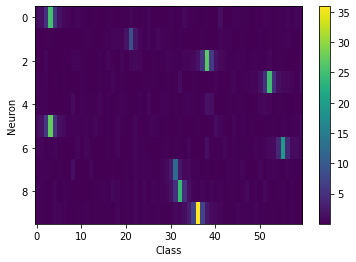

In [56]:
plt.figure( figsize = (6, 4) )

plt.imshow( neuron_class_rates,
            aspect = 'auto',
            interpolation = 'none' )
plt.colorbar()

plt.ylabel( 'Neuron' )
plt.xlabel( 'Class' )

plt.show()

Some helper functions for generating data with Poisson assumptions

In [57]:
def gen_trials( c, n_trials = 1,
                noise_level = 0. ):
    # TODO Super slow
    ret = np.zeros( (n_neurons, n_trials) )
    for i_neuron in range( n_neurons ):
        ret[i_neuron, :] = ( stats.poisson.rvs( neuron_class_rates[i_neuron, c],
                                                size = (n_trials,) )
                             + stats.poisson.rvs( noise_level,
                                                  size = (n_trials,) ) )
    return ret

def gen_data( n_trials,
              noise_level = 0. ):
    # Determine how many trials came from each class
    n_per_class = stats.multinomial.rvs( n_trials, class_prevalence )
    
    # Preallocate return values
    ret_n = np.zeros( (n_neurons, n_trials) )
    ret_c = np.zeros( (n_trials,) )
    
    n_start = 0
    # Sample trials from each class
    for i_class in range( n_classes ):
        n_trials_cur = n_per_class[i_class]
        cur_data = gen_trials( i_class, n_trials = n_trials_cur,
                               noise_level = noise_level )
        n_end = n_start + n_trials_cur
        
        ret_n[:, n_start:n_end] = cur_data
        ret_c[n_start:n_end] = i_class
        
        n_start = n_end
    
    # Rearrange trials randomly (**NO AUTOCORRELATION**)
    new_order = np.random.permutation( np.arange( n_trials ) )
    ret_n = ret_n[:, new_order]
    ret_c = ret_c[new_order].astype( int )
    
    # Transpose the counts to put them in "sklearn" format
    # (Rows are *trials*, columns are *features* [neurons])
    return ret_n.T, ret_c

Simulate the dataset!

In [58]:
n_trials_dataset = 500

dataset_counts, dataset_classes = gen_data( n_trials_dataset )

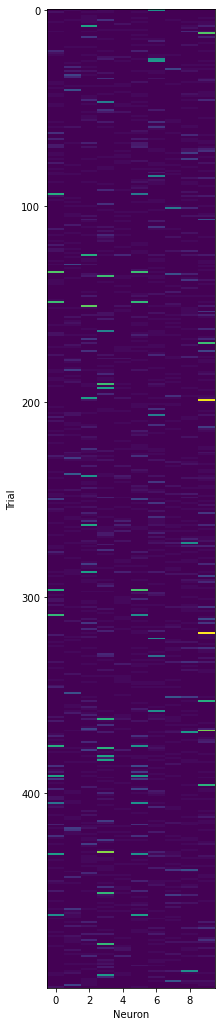

In [59]:
plt.figure( figsize = (3, 18) )
plt.imshow( dataset_counts,
            aspect = 'auto',
            interpolation = 'none' )
plt.xlabel( 'Neuron' )
plt.ylabel( 'Trial' )
plt.show()

---

## Classify!

This is the reusable classifier class

In [60]:
class NBPoissonClassifier:
    """A classifier that uses the naïve Bayes assumption with Poisson variates"""
    
    def __init__( self ):
        # Instance variables
        self.fit_ = False
        self.means_ = None
        self.prior_ = None
        self.n_classes_ = None
        self.n_neurons_ = None
        
    def fit( self, X, y ):
        """Fit the model
        
        Parameters
        ----------
        `X` - Input features (rows are trials, columns are features)
        `y` - Output classes (integers)
        """
        # Determine the shape from the data
        self.n_classes_ = np.max( y ) + 1
        self.n_neurons_ = X.shape[1]
        n_trials = X.shape[0]
        
        # Fit prior using the empirical prevalence of the classes
        self.prior_ = np.zeros( (self.n_classes_,) )
        for c in range( self.n_classes_ ):
            # The empirical prior is the fraction of trials that have this class
            self.prior_[c] = np.sum( y == c ) / n_trials
        
        # Fit the class means using the empirical means
        self.means_ = np.zeros( (self.n_neurons_, self.n_classes_) )
        for c in range( self.n_classes_ ):
            # The empirical mean is the mean of all the trials that have this class
            idx_c = (y == c)
            self.means_[:, c] = np.mean( X[idx_c, :], axis = 0 )
        
        # Set our fit flag
        self.fit_ = True
        
    def class_score_( self, c, xs ):
        """Assign the Bayes' rule output score for feature vector `xs`
        assuming the given class `c`"""
        # TODO This is the slowest possible way to do this
        ret = self.prior_[c]
        # Multiply the prior by each class' pmf
        for i, x in enumerate( xs ):
            ret *= stats.poisson.pmf( x, self.means_[i, c] )
#         print( ret )
        return ret
        
    def class_scores_( self, xs ):
        """Perform `self.class_score_` on the feature vector `xs` for each class"""
        return np.array( [ self.class_score_( c, xs )
                           for c in range( self.n_classes_ ) ] )
    
    def best_class_( self, xs ):
        """Pick the best class given the Bayes' rule class scores for feature vector `xs`"""
        scores = self.class_scores_( xs )
        return np.argmax( scores )
        
    def predict( self, X, verbose = False ):
        """Predict the classes for the data in X
        
        Parameters
        ----------
        `X` - Input features (rows are trials, columns are features)
        `verbose` - Set to `True` for a progress bar (default: `False`)
        """
        
        if not self.fit_:
            raise ValueError( 'Classifier not fit yet!' )
        
        # Determine shape from the data
        n_trials = X.shape[0]
        
        # `it` is for "iterator"
        it = range( n_trials )
        if verbose:
            # If we set the verbose flag, give us a progress bar
            it = tqdm( it )
        
        # The output is the best class for each trial
        ret = np.array( [ self.best_class_( X[i_trial, :] )
                          for i_trial in it ] ).astype( int )
        return ret

Fit the classifier

In [61]:
classifier = NBPoissonClassifier()
classifier.fit( dataset_counts, dataset_classes )

Class means should be the tuning curves

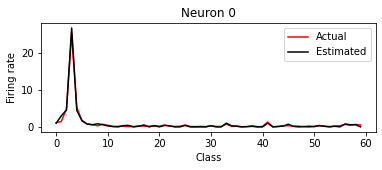

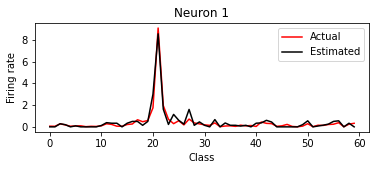

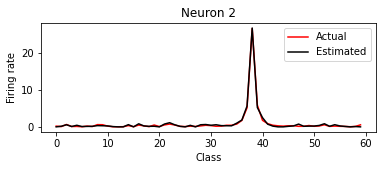

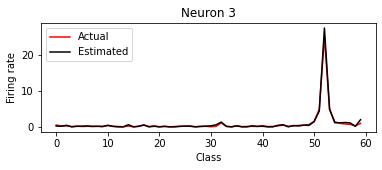

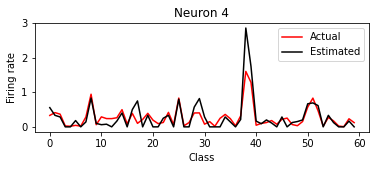

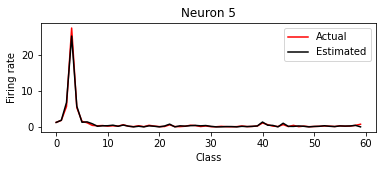

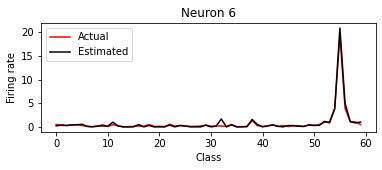

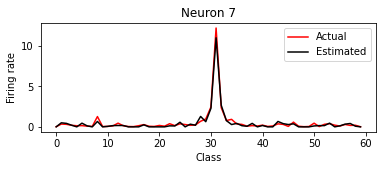

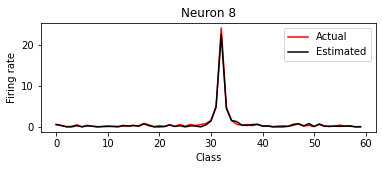

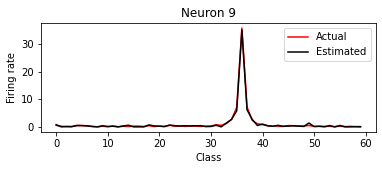

In [62]:
for i_neuron in range( classifier.n_neurons_ ):
    plt.figure( figsize = (6, 2) )
    
    plt.plot( neuron_class_rates[i_neuron, :], 'r-', label = 'Actual' )
    plt.plot( classifier.means_[i_neuron, :], 'k-', label = 'Estimated' )
    
    plt.xlabel( 'Class' )
    plt.ylabel( 'Firing rate' )
    
    plt.title( f'Neuron {i_neuron}' )
    plt.legend()
    
    plt.show()

CHEAT and predict the output based on the data we used for training

In [63]:
dataset_predictions = classifier.predict( dataset_counts, verbose = True )

100%|██████████| 500/500 [00:18<00:00, 27.09it/s]


In [64]:
cheat_accuracy = np.sum( dataset_predictions == dataset_classes ) / n_trials_dataset
print( cheat_accuracy )

0.52


---

## Crossvalidate to get an *actual* estimate of the accuracy

Some helpers for crossvalidation

In [65]:
def crossval_folds( n_trials, n_folds ):
    """Determine crossvalidation 'fold' identifiers for each trial
    ASSUMES THAT THE NUMBER OF FOLDS IS A DIVISOR OF THE NUMBER OF TRIALS
    Must do some more fancy stuff if that is not the case; `sklearn` has some
        built-in stuff to handle this I think"""
    
    ret = np.zeros( (n_trials,) )
    # TODO Assumes even divisors
    n_per_fold = n_trials // n_folds
    
    cur_start = 0
    for i_fold in range( n_folds ):
        cur_end = cur_start + n_per_fold
        ret[cur_start:cur_end] = i_fold
        cur_start = cur_end
        
    return np.random.permutation( ret ).astype( int )

def predict_crossval( X, y, n_folds = 5,
                      verbose = False ):
    """Determine predicted fits for the data *not* cheating, using crossvalidation"""
    
    # Randomly determine CV folds for the data
    n_trials = X.shape[0]
    folds = crossval_folds( n_trials, n_folds )
    
    # Preallocate predicted classes
    y_hat = np.zeros( y.shape )
    
    # `it` is for "iterator"
    it = range( n_folds )
    if verbose:
        it = tqdm( it )
    
    for i_fold in it:
        # These are the trials that we are going to *test* on for the current fold
        filter_test = folds == i_fold
        
        # Split out training and testing data
        # (~ is "elementwise not" in numpy)
        X_train = X[~filter_test, :]
        y_train = y[~filter_test]
        X_test = X[filter_test, :]
        
        # Do the predictions!
        classifier = NBPoissonClassifier()
        classifier.fit( X_train, y_train )
        y_hat[filter_test] = classifier.predict( X_test )
    
    return y_hat.astype( int )

Do crossvalidation on our actual dataset

In [66]:
dataset_predictions_cv = predict_crossval( dataset_counts, dataset_classes,
                                           n_folds = 5,
                                           verbose = True )

100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


In [67]:
cv_accuracy = np.sum( dataset_predictions_cv == dataset_classes ) / n_trials_dataset

In [68]:
print( cv_accuracy )

0.3


Plot a "confusion matrix"

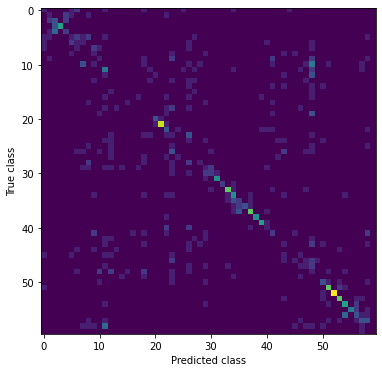

In [69]:
confusion = np.zeros( (n_classes, n_classes) )

for c_true, c_pred in zip( dataset_classes, dataset_predictions_cv ):
    confusion[c_true, c_pred] += 1

plt.figure( figsize = (6, 6) )

plt.imshow( confusion,
            aspect = 'auto',
            interpolation = 'none',
            cmap = 'viridis' )

plt.ylabel( 'True class' )
plt.xlabel( 'Predicted class' )

plt.show()

Get an estimate of not just *perfect* accuracy, but the actual accuracy in *degrees*

In [70]:
cv_errors_raw = dataset_predictions_cv - dataset_classes

# Have to do a little hocus pocus on the errors because they're on the circle
cv_errors = np.array( [ np.minimum( np.abs( cv_errors_raw[i] ), n_classes - np.abs( cv_errors_raw[i] ) )
                       for i in range( cv_errors_raw.shape[0] )] )
degrees_per_class = 360. / n_classes
cv_errors_degrees = degrees_per_class * cv_errors

# Root mean squared error, in degrees
cv_rmse = np.sqrt( np.mean( np.power( cv_errors_degrees, 2. ) ) )
print( f'CV decoding error: {cv_rmse:0.3f}°' )

CV decoding error: 74.404°


---

## Permutation test for "chance" distribution

In [19]:
# This takes forever; for real-world, use like >= 200
n_permutations = 50

perm_accuracies = np.zeros( (n_permutations,) )
for i_permutation in tqdm( range( n_permutations ) ):
    # "Decouple" the features (neuron spike counts) and the classes
    dataset_classes_perm = np.random.permutation( dataset_classes )
    
    # Predict the results using crossvalidation on the permuted data
    dataset_predictions_perm = predict_crossval( dataset_counts, dataset_classes_perm )
    cur_accuracy = np.sum( dataset_predictions_perm == dataset_classes ) / n_trials_dataset
    perm_accuracies[i_permutation] = cur_accuracy

100%|██████████| 50/50 [08:34<00:00, 10.28s/it]


Plot the results!

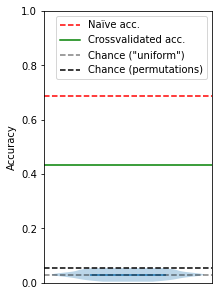

In [20]:
plt.figure( figsize = (3, 5) )

plt.violinplot( [ perm_accuracies ]
                [0],
                showextrema = False,
                showmedians = True )

xl = plt.xlim()
plt.plot( xl, cheat_accuracy * np.array( [1, 1] ), 'r--', label = 'Naïve acc.' )

plt.plot( xl, cv_accuracy * np.array( [1, 1] ), 'g-', label = 'Crossvalidated acc.' )

chance_uniform = 1. / n_classes
plt.plot( xl, chance_uniform * np.array( [1, 1] ), 'k--', alpha = 0.5, label = 'Chance ("uniform")' )

chance_perm = np.quantile( perm_accuracies, 0.95 )
plt.plot( xl, chance_perm * np.array( [1, 1] ), 'k--', label = 'Chance (permutations)' )

plt.xlim( xl )
plt.xticks( [] )

plt.ylim( 0., 1. )
plt.ylabel( 'Accuracy' )

plt.legend()

plt.show()